In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dpks.interpretation import BootstrapInterpreter

from sklearn.datasets import make_classification

In [39]:
from dpks.quant_matrix import QuantMatrix

import pandas as pd
import numpy as np

In [40]:
design_matrix = pd.read_csv(
    #"../tests/input_files/design_sepsis.tsv",
    "../tests/input_files/design_sepsis.tsv",
    sep="\t"
)

In [41]:
design_matrix['group'].value_counts()

group
2    123
1     74
Name: count, dtype: int64

In [54]:
qm = QuantMatrix(
    quantification_file="../tests/input_files/data_sepsis.tsv", #../tests/input_files/data_sepsis.tsv",
    design_matrix_file=design_matrix
)#.impute(method="uniform_percentile", percentile=0.1)
# ).filter().normalize(
#         method="mean",
#         use_rt_sliding_window_filter=True,
#         rt_unit="second",
#         stride=5,
#         minimum_data_points=200,
#     ).quantify(method="maxlfq", top_n=5)

In [55]:
qm = qm.filter(
    
).normalize(
    method="mean", 
    #use_rt_sliding_window_filter=True
).quantify(
    method="top_n", 
    top_n=3, 
    summarization_method="mean"
).filter(
    remove_n_zero_rows=True, 
    max_n_zeros=round(design_matrix.shape[0] * 0.10)
).impute(
    method="neighborhood",
    n_neighbors=5,
    weights="distance"
)

/home/aaron/projects/dpks/DPKS/dpks/quantification.py:94: RuntimeWarning: Mean of empty slice
  quantification: np.ndarray = np.nanmean(


In [56]:
qm = qm.annotate()

In [57]:
df = qm.to_df()

In [58]:
df = df[~df['Gene'].str.contains("IGKV")]

In [59]:
df = df[~df['Gene'].str.contains("IGHV")]
df = df[~df['Gene'].str.contains("IGLV")]

In [60]:
df = df[~df['Gene'].str.startswith("IGK")]
df = df[~df['Gene'].str.startswith("IGL")]
df = df[~df['Gene'].str.startswith("IGH")]

In [61]:
df[df['Gene'].str.contains("IG")]

,Protein,Gene,TM_P1911_190,TM_P1911_191,TM_P1911_192,TM_P1911_193,TM_P1911_194,TM_P1911_196,TM_P1911_197,TM_M2012_010,...,TM_M2012_190,TM_M2012_191,TM_M2012_192,TM_M2012_196,TM_M2012_197,TM_M2012_198,TM_M2012_199,TM_M2012_200,TM_M2012_202,TM_M2012_203
15,P01833,PIGR,19.664880,21.633621,21.670326,21.761844,21.419413,21.397360,22.241675,19.799678,...,20.377831,20.333764,20.073364,21.162501,21.555845,23.446327,23.480785,23.494882,23.119843,23.210732
71,P18065,IGFBP2,21.998225,22.240814,21.976998,22.120705,21.724747,20.547283,20.254232,16.772770,...,20.385260,20.091515,20.109825,19.381308,16.857872,18.236944,19.416844,19.511230,20.716453,19.196851
120,P22692,IGFBP4,20.749932,21.474532,21.067980,20.787196,20.255551,19.684710,18.801411,18.680508,...,18.723023,18.548782,18.564646,19.969960,20.463552,21.014046,21.171358,20.870457,20.346138,20.735572
198,P01344,IGF2,20.518328,20.330360,20.252861,20.531239,20.434945,20.202144,20.034774,19.627413,...,20.607472,20.420237,18.487973,20.547026,20.540157,20.819238,20.686061,20.664008,21.390551,20.661522
201,P35858,IGFALS,19.937623,18.152066,18.520409,18.838000,19.395117,19.843678,19.801360,20.111385,...,21.429625,21.304027,21.273128,21.329476,21.455474,21.551173,21.541847,21.362219,21.765552,21.555803


In [62]:
qm = QuantMatrix(
    quantification_file=df,
    design_matrix_file=design_matrix
)

In [63]:
qm_decoys_added = qm.append(
    method="shuffle",
    feature_column="Protein"
)

In [64]:
qm_decoys_added.row_annotations

,Protein,Decoy,Gene
0,P08603,0,CFH
1,P02671,0,FGA
2,P01042,0,KNG1
3,P00450,0,CP
4,P05156,0,CFI
...,...,...,...
383,decoy_Q562R1,1,NaN
384,decoy_P18428,1,NaN
385,decoy_P07477,1,NaN
386,decoy_P08637,1,NaN


In [65]:
qm_decoys_added = qm_decoys_added.compare(
    method="linregress",
    min_samples_per_group=10,
    comparisons=[(2, 1)]
)

In [66]:
from sklearn.model_selection import cross_val_score
from dpks.classification import Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier
import xgboost


clf = xgboost.XGBClassifier(
    max_depth=2,
    #subsample=0.5,
    reg_lambda=2,
    objective="binary:logistic",
    seed=42
)

#clf = GradientBoostingClassifier()

qm_decoys_added = qm_decoys_added.explain(
    clf,
    comparisons=[(2, 1)],
    n_iterations=10,
    downsample_background=True,
    fillna=True
)

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

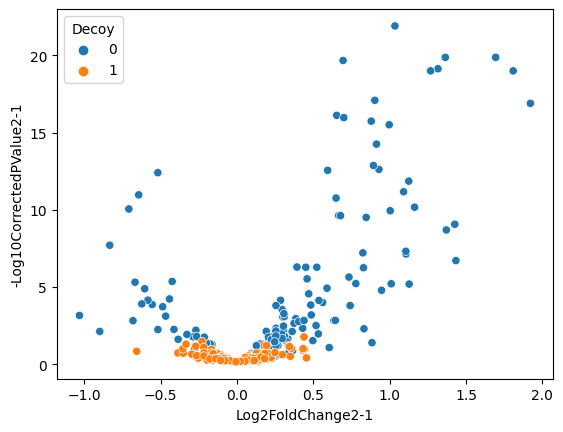

In [67]:
import seaborn as sns


sns.scatterplot(
    data=qm_decoys_added.row_annotations,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1",
    hue="Decoy"
)

In [68]:
qm_decoys_added = qm_decoys_added.evaluate(
    comparisons=[(2, 1)],
    method="basic",
    verbose=True
)

Comparison 2-1: [0.8        0.79069767 0.80620155]


In [69]:
qm_decoys_added.row_annotations

,Protein,Decoy,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,MeanSHAP2-1,MeanRank2-1,FeatureScore2-1,FeatureQValue2-1
0,P08603,0,CFH,0.058731,25.937840,25.836984,0.577383,0.541758,0.100856,0.228219,123,74,0.326876,0.485617,0.000000,212.45,-3.023954,0.426282
1,P02671,0,FGA,0.007655,29.777771,29.791928,0.621469,0.796235,-0.014158,0.890147,123,74,0.673771,0.171488,0.000000,212.45,1.231761,0.079710
2,P01042,0,KNG1,0.062431,25.763998,25.669992,0.391464,0.413975,0.094007,0.113664,123,74,0.196698,0.706200,0.000000,212.45,0.646688,0.116883
3,P00450,0,CP,0.146754,27.023217,26.831854,0.393929,0.460681,0.191363,0.002373,123,74,0.007416,2.129827,0.000000,212.45,7.526407,0.000000
4,P05156,0,CFI,0.058602,23.434909,23.333678,0.613447,0.511778,0.101231,0.237170,123,74,0.336195,0.473409,0.000000,212.45,-4.746804,0.482574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,decoy_Q562R1,1,NaN,0.041819,21.799399,21.878040,1.010839,1.145508,-0.078641,0.617567,123,74,0.591721,0.227883,0.000000,212.45,-3.252648,0.445455
384,decoy_P18428,1,NaN,0.074962,23.679339,23.819526,1.138194,0.972736,-0.140187,0.380692,123,74,0.441732,0.354841,0.004907,194.45,-2.541152,0.366906
385,decoy_P07477,1,NaN,0.237644,26.478374,26.023537,2.824782,3.271119,0.454838,0.306526,123,74,0.386673,0.412656,0.000000,212.45,-2.820464,0.400673
386,decoy_P08637,1,NaN,0.135952,20.728996,20.480527,1.010234,0.987015,0.248469,0.095013,123,74,0.174435,0.758367,0.000000,212.45,0.064680,0.141104


<Axes: xlabel='FeatureScore2-1', ylabel='Count'>

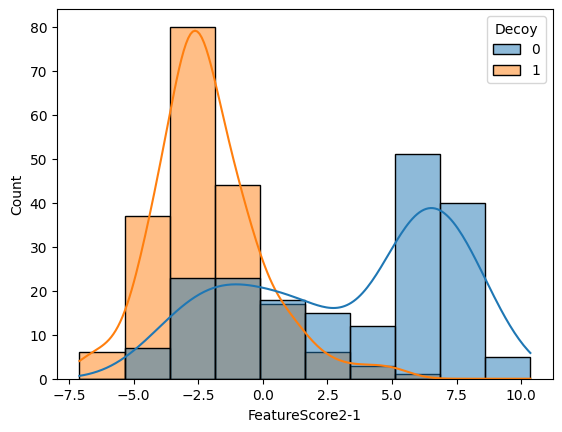

In [70]:
sns.histplot(
    data=qm_decoys_added.row_annotations,
    x="FeatureScore2-1",
    hue="Decoy",
    bins="auto",
    kde=True
)

In [71]:
qm_decoys_added.row_annotations.sort_values("FeatureScore2-1", ascending=False).head(10)

,Protein,Decoy,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,MeanSHAP2-1,MeanRank2-1,FeatureScore2-1,FeatureQValue2-1
181,P22352,0,GPX3,0.226605,22.746843,22.440090,0.546276,0.498566,0.306754,1.213294e-04,123,74,5.296126e-04,3.276042,0.043534,155.10,10.352349,0.0
163,P22792,0,CPN2,0.221445,23.649120,23.339464,0.570503,0.521088,0.309657,2.003177e-04,123,74,8.221995e-04,3.085023,0.000000,212.45,8.986595,0.0
108,P41222,0,PTGDS,0.616319,19.987056,19.141235,0.782493,0.858999,0.845822,3.133417e-11,123,74,3.077463e-10,9.511807,0.000000,212.45,8.975525,0.0
84,P02747,0,C1QC,0.192081,24.481055,24.177132,0.718221,0.559094,0.303923,2.219284e-03,123,74,7.037718e-03,2.152568,0.000000,212.45,8.929410,0.0
145,P01591,0,JCHAIN,0.664082,25.596040,24.489269,1.048110,1.517458,1.106771,8.951091e-09,123,74,7.239853e-08,7.140270,0.013189,174.70,8.888536,0.0
73,O75636,0,FCN3,0.558225,22.541882,21.875895,0.547528,0.756050,0.665987,2.211612e-11,123,74,2.339205e-10,9.630932,0.003677,193.95,8.602538,0.0
93,P00736,0,C1R,0.216861,23.385626,23.085513,0.519095,0.569249,0.300113,2.170710e-04,123,74,8.778605e-04,3.056574,0.000000,212.45,8.482099,0.0
32,P04114,0,APOB,0.312336,25.158984,24.675987,0.687596,0.878885,0.482996,3.059644e-05,123,74,1.450693e-04,3.838424,0.000000,212.45,8.481040,0.0
50,P02649,0,APOE,0.349912,25.597427,25.036674,0.883782,0.838697,0.560753,1.990074e-05,123,74,9.950371e-05,4.002161,0.000000,212.45,8.421376,0.0
124,P59665,0,DEFA1,1.147895,22.913870,21.549588,0.839488,0.804585,1.364281,1.089154e-22,123,74,1.331069e-20,19.875799,0.490161,7.70,8.360959,0.0


In [72]:
qm_decoys_added.row_annotations[qm_decoys_added.row_annotations['FeatureQValue2-1'] <= 0.01]

,Protein,Decoy,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,MeanSHAP2-1,MeanRank2-1,FeatureScore2-1,FeatureQValue2-1
3,P00450,0,CP,0.146754,27.023217,26.831854,0.393929,0.460681,0.191363,2.373136e-03,123,74,7.416051e-03,2.129827,0.000000,212.45,7.526407,0.0
13,P04196,0,HRG,0.179167,23.700973,23.970649,0.603624,0.539834,-0.269676,1.941223e-03,123,74,6.280428e-03,2.202011,0.000000,212.45,6.208581,0.0
14,P01833,0,PIGR,0.580415,21.488813,20.478902,1.526319,0.997766,1.009911,1.007854e-06,123,74,6.159107e-06,5.210482,0.008445,193.00,5.602364,0.0
15,P00751,0,CFB,0.179563,26.284413,26.016361,0.452006,0.728379,0.268052,1.766032e-03,123,74,5.781651e-03,2.237948,0.000000,212.45,8.211589,0.0
16,P19823,0,ITIH2,0.598971,24.507470,25.151714,0.655951,0.380546,-0.644244,8.207451e-13,123,74,1.074785e-11,10.968678,0.393790,10.20,6.299769,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,P80188,0,LCN2,1.252938,20.900065,18.978541,1.325281,1.275290,1.921524,4.156362e-19,123,74,1.270000e-17,16.896196,0.208139,74.90,5.489047,0.0
189,Q562R1,0,ACTBL2,0.297305,22.023356,21.505788,0.874168,1.255792,0.517568,8.620013e-04,123,74,3.119084e-03,2.505973,0.000000,212.45,5.681589,0.0
190,P18428,0,LBP,0.520434,24.043172,23.214777,1.033711,0.952477,0.828395,7.965648e-08,123,74,5.616803e-07,6.250511,0.158099,112.90,6.574099,0.0
192,P08637,0,FCGR3A,1.074365,21.112050,19.843830,0.742287,0.888284,1.268221,2.280074e-21,123,74,9.990135e-20,19.000429,0.210117,34.30,5.568494,0.0


In [73]:
qm_decoys_added.row_annotations['cutoff'] = np.where(
    qm_decoys_added.row_annotations['FeatureQValue2-1'] <= 0.01, 1, 0
)

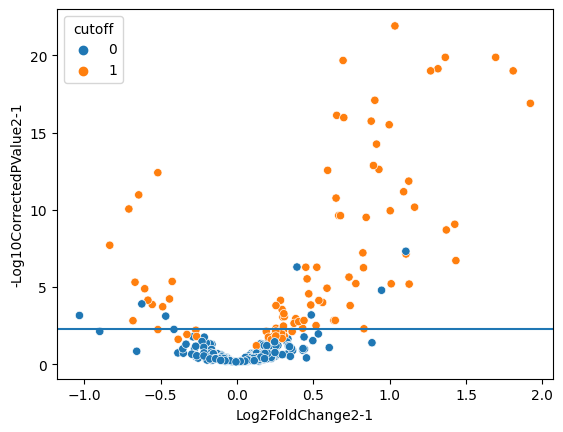

In [75]:
ax = sns.scatterplot(
    data=qm_decoys_added.row_annotations,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1",
    hue="cutoff"
)

ax.axhline(-np.log(0.1))